SCENARIO SIMULATION

In [3]:
import pandas as pd
import numpy as np
from math import log

WeekMap = pd.read_excel("DFs\\WeekMapDF.xlsx")
BeerDF  = pd.read_excel("DFs\\BeerDF.xlsx")
CustDemo= pd.read_excel("DFs\\CustDemographicDF.xlsx")
StoreTransactionsDF = pd.read_excel('DFs\\StoreTransactionsDF.xlsx')
CustTransactionsDF = pd.read_excel('DFs\\CustTransactionsDF.xlsx')
BeerTransactionsDF = pd.read_excel('DFs\\BeerTransactionsDF.xlsx')
STORE_ID = 257871

In [4]:
StoreTX = StoreTransactionsDF[StoreTransactionsDF['IRI_KEY'] == STORE_ID].copy()
CustTX = CustTransactionsDF[CustTransactionsDF['IRI_KEY'] == STORE_ID].copy()
BeerTX = BeerTransactionsDF[BeerTransactionsDF['IRI_KEY'] == STORE_ID].copy()

# -------------------------------
# Brand grouping & merge
# -------------------------------
top_brands = ["MILLER LITE", "MICHELOB GOLDEN DRAFT LIGHT", "MILWAUKEES BEST LIGHT"]
BeerDF["BRAND_GRP"] = BeerDF["BRAND"].where(BeerDF["BRAND"].isin(top_brands), "OTHER")
StoreTX["UPC"] = StoreTX["UPC"].astype(str)
BeerDF["UPC"] = BeerDF["UPC"].astype(str)
StoreTX = StoreTX.merge(BeerDF[["UPC","BRAND_GRP"]], on="UPC", how="left")

brands_all = ["MILLER LITE", "MICHELOB GOLDEN DRAFT LIGHT", "MILWAUKEES BEST LIGHT", "OTHER"]

# -------------------------------
# Baseline window
# -------------------------------
min_date = max(df["WEEK_DATE"].min() for df in (StoreTX, CustTX))
max_date = min(df["WEEK_DATE"].max() for df in (StoreTX, CustTX))
weeks = WeekMap[(WeekMap["WEEK_DATE"] >= min_date) & (WeekMap["WEEK_DATE"] <= max_date)].sort_values("WEEK_DATE")["WEEK"].tolist()
if len(weeks) > 52:
    weeks = weeks[-52:]

StoreTX_b = StoreTX[StoreTX["WEEK"].isin(weeks)].copy()
CustTX_b  = CustTX[CustTX["WEEK"].isin(weeks)].copy()
BeerTX_b  = BeerTX[BeerTX["WEEK"].isin(weeks)].copy()

# Trips & incidence baseline
trips_week = CustTX_b.groupby("WEEK", as_index=False).size().rename(columns={"size":"TRIPS"})
beer_trips_week = BeerTX_b.groupby("WEEK", as_index=False).size().rename(columns={"size":"BEER_TXNS"})
base_week = (trips_week.merge(beer_trips_week, on="WEEK", how="left").fillna({"BEER_TXNS":0})
             .merge(WeekMap[["WEEK","WEEK_DATE"]], on="WEEK", how="left"))
base_week["INCIDENCE_RATE"] = np.where(base_week["TRIPS"]>0, base_week["BEER_TXNS"]/base_week["TRIPS"], 0.0)

# Shares baseline
brand_units = StoreTX_b.groupby(["WEEK","BRAND_GRP"], as_index=False)["UNITS"].sum()
share_week = brand_units.pivot_table(index="WEEK", columns="BRAND_GRP", values="UNITS", fill_value=0)
share_week = share_week.div(share_week.sum(axis=1), axis=0).reset_index()

# Avg units per beer txn
if "BEER_UNITS" in BeerTX_b.columns and (BeerTX_b["BEER_PURCHASED"]==1).any():
    avg_units_per_txn = BeerTX_b.loc[BeerTX_b["BEER_PURCHASED"]==1, "BEER_UNITS"].mean()
else:
    total_units = brand_units["UNITS"].sum()
    total_beer_txns = base_week["BEER_TXNS"].sum() if base_week["BEER_TXNS"].sum() > 0 else 1
    avg_units_per_txn = total_units / total_beer_txns

# Avg price per brand
avg_price_by_brand = StoreTX_b.groupby("BRAND_GRP")["UNIT_PRICE"].mean().to_dict()
if any(pd.isna(v) for v in avg_price_by_brand.values()):
    overall_price = StoreTX_b["UNIT_PRICE"].mean()
    for b in brands_all:
        if pd.isna(avg_price_by_brand.get(b, np.nan)):
            avg_price_by_brand[b] = overall_price

BASELINE = {
    "weeks": weeks,
    "mean_incidence": float(base_week["INCIDENCE_RATE"].mean()),
    "mean_shares": share_week.set_index("WEEK").mean(numeric_only=True).to_dict(),
    "trips_per_week": trips_week.set_index("WEEK")["TRIPS"].to_dict(),
    "avg_units_per_txn": float(avg_units_per_txn),
    "avg_price_by_brand": avg_price_by_brand
}

# -------------------------------
# Coefs
# -------------------------------
BETA_FEATURE = 0.085404
BETA_FEATURE_LAG1 = -0.037621

MNL_COEFS = {
    "MILLER LITE": {"AD_FEATURE_INTENSITY_LAG1": 1.515847, "AD_PRICERED_INTENSITY_LAG1": 0.457910, "LOG_PRICE_OZ": -0.204714},
    "MICHELOB GOLDEN DRAFT LIGHT": {"AD_FEATURE_INTENSITY_LAG1": 0.039072, "AD_PRICERED_INTENSITY_LAG1": 0.027875, "LOG_PRICE_OZ": 1.076698},
    "MILWAUKEES BEST LIGHT": {"AD_FEATURE_INTENSITY_LAG1": -2.491792, "AD_PRICERED_INTENSITY_LAG1": -0.313993, "LOG_PRICE_OZ": -0.078332},
    "OTHER": {"AD_FEATURE_INTENSITY_LAG1": 0.936873, "AD_PRICERED_INTENSITY_LAG1": -0.171793, "LOG_PRICE_OZ": -0.793651},
}

# -------------------------------
# High-traffic weeks (80th pct)
# -------------------------------
bt = BeerTX_b[["PANID","WEEK","MINUTE"]].drop_duplicates()
beer_trips_w = bt.groupby("WEEK", as_index=False).size().rename(columns={"size":"BEER_TRIPS"})
k = 20
candidates = beer_trips_w.sort_values("BEER_TRIPS", ascending=False)["WEEK"].tolist()
picked = []
for w in candidates:
    if all(abs(w - p) > 1 for p in picked):  # >1 = at least 1-week gap
        picked.append(w)
    if len(picked) == k:
        break
feature_weeks = set(picked)

#thr = beer_trips_w["BEER_TRIPS"].quantile(0.80) if len(beer_trips_w)>0 else 0
#feature_weeks = set(sorted(beer_trips_w.loc[beer_trips_w["BEER_TRIPS"]>=thr,"WEEK"].tolist()))

# -------------------------------
# Scenario engine (UPDATED)
# -------------------------------
from math import log  # ensure log is available

def run_scenario(
    ad_feature_bump=None,
    ad_pricered_bump=None,
    price_discount_pct=None,
    promo_cost_per_week=50.0,        # $50 ONLY on promo weeks
    contact_cost_per_email=0.03,     # $0.03 per email (ONLY on promo weeks)
    n_targets=126,                   # number of targeted PANIDs per promo week
    margin_rate=0.25
):
    ad_feature_bump = ad_feature_bump or {}
    ad_pricered_bump = ad_pricered_bump or {}
    price_discount_pct = price_discount_pct or {}

    rows = []
    weeks_sorted = sorted(BASELINE["weeks"])
    for w in weeks_sorted:
        trips = BASELINE["trips_per_week"].get(w, 0)
        if trips == 0:
            continue

        # Identify promo (feature) weeks
        is_feat = 1 if w in feature_weeks else 0
        prev_feat = 1 if (w-1) in feature_weeks else 0

        # ---- Purchase incidence (apply feature effects) ----
        odds = BASELINE["mean_incidence"] / (1 - BASELINE["mean_incidence"] + 1e-12)
        odds_new = odds * np.exp(BETA_FEATURE*is_feat + BETA_FEATURE_LAG1*prev_feat)
        p_new = float(odds_new / (1 + odds_new))

        # ---- Brand choice (apply ad + price effects) ----
        shares_base = {b: max(BASELINE["mean_shares"].get(b, 0.0), 1e-12) for b in brands_all}
        delta_u = {}
        for b in brands_all:
            du = 0.0
            if is_feat == 1:
                du += MNL_COEFS[b]["AD_FEATURE_INTENSITY_LAG1"]  * ad_feature_bump.get(b, 0.0)
                du += MNL_COEFS[b]["AD_PRICERED_INTENSITY_LAG1"] * ad_pricered_bump.get(b, 0.0)
            d = price_discount_pct.get(b, 0.0)
            if -0.5 < d < 1.0:
                du += MNL_COEFS[b]["LOG_PRICE_OZ"] * log(1 - d)
            delta_u[b] = du

        numer = {b: shares_base[b] * np.exp(delta_u[b]) for b in brands_all}
        denom = sum(numer.values())
        shares_new = {b: numer[b]/denom for b in brands_all}

        # ---- Units & revenue ----
        units_total = p_new * trips * BASELINE["avg_units_per_txn"]
        brand_units_dict = {b: units_total * shares_new[b] for b in brands_all}

        price_eff = {}
        for b in brands_all:
            base_p = BASELINE["avg_price_by_brand"].get(b, np.nan)
            if pd.isna(base_p):
                base_p = np.nanmean(list(BASELINE["avg_price_by_brand"].values()))
            d = price_discount_pct.get(b, 0.0)
            price_eff[b] = base_p * (1 - d)

        revenue_b = {b: brand_units_dict[b] * price_eff[b] for b in brands_all}
        revenue = sum(revenue_b.values())
        gross_profit = revenue * margin_rate

        # ---- CHANGED: Promo cost only on promo (feature) weeks ----
        if is_feat == 1:
            promo_cost = promo_cost_per_week + (n_targets * contact_cost_per_email)
        else:
            promo_cost = 0.0

        net_profit = gross_profit - promo_cost

        row = {
            "WEEK": w,
            "REVENUE_TOTAL": revenue,
            "GROSS_PROFIT": gross_profit,
            "PROMO_COST": promo_cost,
            "NET_PROFIT": net_profit
        }
        for b in brands_all:
            row[f"UNITS_{b}"] = brand_units_dict[b]
        rows.append(row)

    out = pd.DataFrame(rows)
    unit_cols = [f"UNITS_{b}" for b in brands_all]
    totals = out[unit_cols].sum()
    total_units = totals.sum() if totals.sum() > 0 else 1.0
    mix = {f"MIX_{b}": float(totals[f"UNITS_{b}"]/total_units) for b in brands_all}
    sums = out[["REVENUE_TOTAL","GROSS_PROFIT","PROMO_COST","NET_PROFIT"]].sum().to_dict()
    return out, sums, mix

# -------------------------------
# Baseline (no promo/price changes)
# -------------------------------
PROMO_COST = 50.0   # per PROMO week only
MARGIN = 0.25
baseline_df, baseline_sums, baseline_mix = run_scenario(
    ad_feature_bump={},
    ad_pricered_bump={},
    price_discount_pct={},
    promo_cost_per_week=PROMO_COST,
    contact_cost_per_email=0.03,
    n_targets=126,
    margin_rate=MARGIN
)

# -------------------------------
# Scenarios (8) — unchanged logic, but pass email params too
# -------------------------------
scenarios = {
    "A1_ML_FeaturePlus_Discount2%": {
        "ad_feature_bump": {"MILLER LITE": 0.5},
        "ad_pricered_bump": {"MILLER LITE": 0.3},
        "price_discount_pct": {"MILLER LITE": 0.02}
    },
    "A2a_ML_FeaturePlus_Discount1%": {
        "ad_feature_bump": {"MILLER LITE": 0.5},
        "ad_pricered_bump": {"MILLER LITE": 0.3},
        "price_discount_pct": {"MILLER LITE": 0.01}
    },
    "A2b_ML_FeaturePlus_Discount3%": {
        "ad_feature_bump": {"MILLER LITE": 0.5},
        "ad_pricered_bump": {"MILLER LITE": 0.3},
        "price_discount_pct": {"MILLER LITE": 0.03}
    },
    "A3_ML_FeatureOnly_NoPrice": {
        "ad_feature_bump": {"MILLER LITE": 0.5},
        "ad_pricered_bump": {},
        "price_discount_pct": {}
    },
    "B4_MIC_OffPromo_PriceUp2%": {
        "ad_feature_bump": {},
        "ad_pricered_bump": {},
        "price_discount_pct": {"MICHELOB GOLDEN DRAFT LIGHT": -0.02}
    },
    "B5_MIC_Feature_Modest_NoPrice": {
        "ad_feature_bump": {"MICHELOB GOLDEN DRAFT LIGHT": 0.2},
        "ad_pricered_bump": {},
        "price_discount_pct": {}
    },
    "C6_MBL_QuietDiscount1%_NoAds": {
        "ad_feature_bump": {},
        "ad_pricered_bump": {},
        "price_discount_pct": {"MILWAUKEES BEST LIGHT": -0.01}
    },
    "C7_MBL_QuietDiscount2%_NoAds": {
        "ad_feature_bump": {},
        "ad_pricered_bump": {},
        "price_discount_pct": {"MILWAUKEES BEST LIGHT": -0.02}
    },
}

summary_rows = []
scenario_details = {}
for name, params in scenarios.items():
    df, sums, mix = run_scenario(
        ad_feature_bump=params.get("ad_feature_bump", {}),
        ad_pricered_bump=params.get("ad_pricered_bump", {}),
        price_discount_pct=params.get("price_discount_pct", {}),
        promo_cost_per_week=PROMO_COST,
        contact_cost_per_email=0.03,
        n_targets=126,
        margin_rate=MARGIN
    )
    scenario_details[name] = {"df": df, "sums": sums, "mix": mix}
    row = {
        "Scenario": name,
        "Δ Revenue": sums["REVENUE_TOTAL"] - baseline_sums["REVENUE_TOTAL"],
        "Δ Gross Profit": sums["GROSS_PROFIT"] - baseline_sums["GROSS_PROFIT"],
        "Δ Net Profit": sums["NET_PROFIT"] - baseline_sums["NET_PROFIT"],
    }
    for b in brands_all:
        row[f"Mix_{b}"] = mix[f"MIX_{b}"]
        row[f"Δpp_{b}"] = 100*(mix[f"MIX_{b}"] - baseline_mix[f"MIX_{b}"])
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values("Δ Net Profit", ascending=False).reset_index(drop=True)

# Build "best mix": pick best per-brand and combine (unchanged)
def pick_best(candidates):
    part = summary_df[summary_df["Scenario"].isin(candidates)].copy()
    if part.empty:
        return None
    return part.sort_values("Δ Net Profit", ascending=False).iloc[0]["Scenario"]

ml_best  = pick_best(["A1_ML_FeaturePlus_Discount2%","A2a_ML_FeaturePlus_Discount1%","A2b_ML_FeaturePlus_Discount3%","A3_ML_FeatureOnly_NoPrice"])
mic_best = pick_best(["B4_MIC_OffPromo_PriceUp2%","B5_MIC_Feature_Modest_NoPrice"])
mbl_best = pick_best(["C6_MBL_QuietDiscount1%_NoAds","C7_MBL_QuietDiscount2%_NoAds"])

mix_ad_feat, mix_ad_pr, mix_price = {}, {}, {}
if ml_best:
    p = scenarios[ml_best]
    mix_ad_feat.update(p.get("ad_feature_bump", {}))
    mix_ad_pr.update(p.get("ad_pricered_bump", {}))
    mix_price.update(p.get("price_discount_pct", {}))
if mic_best:
    p = scenarios[mic_best]
    mix_ad_feat.update(p.get("ad_feature_bump", {}))
    mix_ad_pr.update(p.get("ad_pricered_bump", {}))
    mix_price.update(p.get("price_discount_pct", {}))
if mbl_best:
    p = scenarios[mbl_best]
    mix_ad_feat.update(p.get("ad_feature_bump", {}))
    mix_ad_pr.update(p.get("ad_pricered_bump", {}))
    mix_price.update(p.get("price_discount_pct", {}))

mix_df, mix_sums, mix_mix = run_scenario(
    ad_feature_bump=mix_ad_feat,
    ad_pricered_bump=mix_ad_pr,
    price_discount_pct=mix_price,
    promo_cost_per_week=PROMO_COST,
    contact_cost_per_email=0.03,
    n_targets=126,
    margin_rate=MARGIN
)

mix_row = {
    "Scenario": f"MIX({ml_best} + {mbl_best} + {mic_best})",
    "Δ Revenue": mix_sums["REVENUE_TOTAL"] - baseline_sums["REVENUE_TOTAL"],
    "Δ Gross Profit": mix_sums["GROSS_PROFIT"] - baseline_sums["GROSS_PROFIT"],
    "Δ Net Profit": mix_sums["NET_PROFIT"] - baseline_sums["NET_PROFIT"],
}
for b in brands_all:
    mix_row[f"Mix_{b}"] = mix_mix[f"MIX_{b}"]
    mix_row[f"Δpp_{b}"] = 100*(mix_mix[f"MIX_{b}"] - baseline_mix[f"MIX_{b}"])

summary_with_mix = pd.concat([pd.DataFrame([mix_row]), summary_df], ignore_index=True).sort_values("Δ Net Profit", ascending=False).reset_index(drop=True)

print("Scenario Ranking — Δ Net Profit (with brand mix)")
print(summary_with_mix)


Scenario Ranking — Δ Net Profit (with brand mix)
                                            Scenario   Δ Revenue  \
0  MIX(A3_ML_FeatureOnly_NoPrice + C7_MBL_QuietDi...  158.056604   
1                          A3_ML_FeatureOnly_NoPrice   96.622804   
2                      A2a_ML_FeaturePlus_Discount1%   84.035768   
3                          B4_MIC_OffPromo_PriceUp2%   53.436872   
4                       A1_ML_FeaturePlus_Discount2%   47.862765   
5                      A2b_ML_FeaturePlus_Discount3%   11.567765   
6                       C7_MBL_QuietDiscount2%_NoAds   10.859451   
7                       C6_MBL_QuietDiscount1%_NoAds    5.434490   
8                      B5_MIC_Feature_Modest_NoPrice    1.844693   

   Δ Gross Profit  Δ Net Profit  Mix_MILLER LITE  Δpp_MILLER LITE  \
0       39.514151     39.514151         0.135682         3.824263   
1       24.155701     24.155701         0.135854         3.841494   
2       21.008942     21.008942         0.145433         4.7993

--------------------------------------------------------------------------------------------------------------------------------------------

UPLIFT MODEL

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

CONTACT_COST = 0.03
MARGIN = 0.25
STORE_ID = 257871

BeerTransactionsDF = pd.read_excel("DFs\\BeerTransactionsDF.xlsx")
StoreTransactionsDF = pd.read_excel("DFs\\StoreTransactionsDF.xlsx")
CustTransactionsDF  = pd.read_excel("DFs\\CustTransactionsDF.xlsx")
CustDemo= pd.read_excel("DFs\\CustDemographicDF.xlsx")
WeekMap = pd.read_excel("DFs\\WeekMapDF.xlsx")

BeerTX  = BeerTransactionsDF[BeerTransactionsDF["IRI_KEY"] == STORE_ID].copy()
StoreTX = StoreTransactionsDF[StoreTransactionsDF["IRI_KEY"] == STORE_ID].copy()
CustTX  = CustTransactionsDF[CustTransactionsDF["IRI_KEY"] == STORE_ID].copy()

In [5]:
# Store-week promo & treatment (joint feature & price reduction)
StoreTX["FEATURE_SCORE"] = (StoreTX["FEATURE"] > 0).astype(int)
StoreTX["PRICE_REDUCTION_SCORE"] = (StoreTX["PRICE_REDUCTION"] > 0).astype(int)
StoreTX["DISPLAY_SCORE"] = (StoreTX["DISPLAY"] > 0).astype(int)

promo_summary = (
    StoreTX.groupby(["IRI_KEY","WEEK_DATE"], as_index=False)
           .agg(FEATURE_SCORE=("FEATURE_SCORE","sum"),
                PRICE_REDUCTION_SCORE=("PRICE_REDUCTION_SCORE","sum"),
                DISPLAY_SCORE=("DISPLAY_SCORE","sum"))
)
promo_summary["TREATMENT"] = ((promo_summary["FEATURE_SCORE"]>0) & (promo_summary["PRICE_REDUCTION_SCORE"]>0)).astype(int)

# Modeling DF
df = (
    CustTX[["PANID","WEEK_DATE","IRI_KEY","MINUTE","TRIP_COST"]]
    .merge(BeerTX[["PANID","WEEK_DATE","IRI_KEY","MINUTE","BEER_PURCHASED","IS_HOLIDAY"]],
           on=["PANID","WEEK_DATE","IRI_KEY","MINUTE"], how="left")
    .merge(WeekMap[["WEEK_DATE","SEASON"]], on="WEEK_DATE", how="left")
    .merge(CustDemo[["PANID","INCOME","RESIDENCE_TYPE","AGE_HH","EDU_HH","OCU_HH","RACE"]],
           on="PANID", how="left")
    .merge(promo_summary[["WEEK_DATE","TREATMENT","FEATURE_SCORE","PRICE_REDUCTION_SCORE","DISPLAY_SCORE"]],
           on="WEEK_DATE", how="left")
)

df["TRIP_COST"] = np.log1p(df["TRIP_COST"])
for c in ["BEER_PURCHASED","IS_HOLIDAY","TREATMENT","FEATURE_SCORE","PRICE_REDUCTION_SCORE","DISPLAY_SCORE"]:
    df[c] = df[c].fillna(0).astype(int)
df["DAY_OF_WEEK"] = df["MINUTE"].floordiv(1440)

def collapse_income(x):
    if pd.isna(x): return np.nan
    if x <= 4: return "Low"
    elif x <= 7: return "LowerMid"
    elif x <= 10: return "UpperMid"
    else: return "High"
df["INCOME_BIN"] = df["INCOME"].apply(collapse_income)

def collapse_age(x):
    if pd.isna(x): return np.nan
    if x <= 2: return "Young"
    elif x <= 4: return "Middle"
    else: return "Older"
df["AGE_HH_BIN"] = df["AGE_HH"].apply(collapse_age)

cust_loyalty = df.groupby("PANID").agg(
    beer_trips=("BEER_PURCHASED","sum"),
    total_trips=("WEEK_DATE","count")
).reset_index()
cust_loyalty["FREQUENCY_RATIO"] = np.where(cust_loyalty["total_trips"]>0, cust_loyalty["beer_trips"]/cust_loyalty["total_trips"], 0.0)

def frequency_category(r):
    if r < 0.2: return "Rare"
    elif r < 0.5: return "Frequent"
    else: return "Loyal"
cust_loyalty["FREQUENCY"] = cust_loyalty["FREQUENCY_RATIO"].apply(frequency_category)
df = df.merge(cust_loyalty[["PANID","FREQUENCY"]], on="PANID", how="left")

df["Y"] = df["BEER_PURCHASED"].astype(int)

# Features (drop direct promo fields to avoid leakage)
ordinal_cols = ["EDU_HH","OCU_HH","DISPLAY_SCORE"]
nominal_cols = ["INCOME_BIN","AGE_HH_BIN","SEASON","RESIDENCE_TYPE","RACE","FREQUENCY","DAY_OF_WEEK","IS_HOLIDAY"]
X_nom = pd.get_dummies(df[nominal_cols].astype("category"), drop_first=True)
X_num = pd.DataFrame(StandardScaler().fit_transform(df[["TRIP_COST"]]), columns=["TRIP_COST"], index=df.index)
X_base = pd.concat([df[ordinal_cols].copy(), X_nom, X_num], axis=1)

T = df["TREATMENT"].astype(int)
X_tx = X_base.multiply(T, axis=0); X_tx.columns = [f"T_{c}" for c in X_tx.columns]
X = pd.concat([X_base, T.rename("TREATMENT"), X_tx], axis=1)

# Split
X_train, X_test, y_train, y_test, T_train, T_test, panid_train, panid_test = train_test_split(
    X, df["Y"].astype(int), T, df["PANID"], test_size=0.30, random_state=42, stratify=T
)

# Fit
clf = LogisticRegression(penalty="l1", solver="saga", max_iter=2000, n_jobs=-1, C=1.0, verbose=0)
clf.fit(X_train, y_train)

# Score uplift
def build_matrix_for_t(X_part, tval):
    Xb = X_part.copy()
    to_drop = [c for c in Xb.columns if c=="TREATMENT" or c.startswith("T_")]
    if to_drop: Xb = Xb.drop(columns=to_drop)
    Tcol = pd.Series(tval, index=Xb.index, name="TREATMENT")
    Xtx = Xb.multiply(tval, axis=0); Xtx.columns = [f"T_{c}" for c in Xtx.columns]
    return pd.concat([Xb, Tcol, Xtx], axis=1)

X1 = build_matrix_for_t(X_test, 1)
X0 = build_matrix_for_t(X_test, 0)
p1 = clf.predict_proba(X1)[:,1]
p0 = clf.predict_proba(X0)[:,1]
uplift = p1 - p0

# Deciles
eval_df = pd.DataFrame({
    "PANID": panid_test.values,
    "uplift": uplift,
    "y": y_test.values,
    "t": T_test.values
}).sort_values("uplift", ascending=False).reset_index(drop=True)

n = len(eval_df)
eval_df["bucket"] = (np.floor(np.arange(n)/max(1, n/10))).astype(int).clip(0,9)
decile = eval_df.groupby("bucket", as_index=False).agg(
    customers=("y","size"),
    treated=("t","sum"),
    avg_uplift=("uplift","mean")
)
decile["pct_customers"] = decile["customers"]/n

# Economics
# U (units/beer trip)
U = BeerTX.loc[BeerTX["BEER_PURCHASED"]==1, "BEER_UNITS"].mean()

# P for treated (joint promo) weeks, weighted by units
promo_weeks = promo_summary.copy()
treated_weeks = set(promo_weeks.loc[promo_weeks["TREATMENT"] == 1, "WEEK_DATE"])
treated_mask = StoreTX["WEEK_DATE"].isin(treated_weeks)
P = (StoreTX.loc[treated_mask, "UNIT_PRICE"] * StoreTX.loc[treated_mask, "UNITS"]).sum() / StoreTX.loc[treated_mask, "UNITS"].sum()

tbl = decile.sort_values("bucket").reset_index(drop=True).copy()
tbl["IncrementalGrossProfit"] = tbl["avg_uplift"] * tbl["customers"] * U * P * MARGIN
tbl["ContactCost"] = tbl["customers"] * CONTACT_COST
tbl["MarginalDeltaProfit"] = tbl["IncrementalGrossProfit"] - tbl["ContactCost"]
tbl["CumulativeDeltaProfit"] = tbl["MarginalDeltaProfit"].cumsum()
total_rows = tbl["customers"].sum()
tbl["CumulativePctRows"] = tbl["customers"].cumsum() / (total_rows if total_rows>0 else 1)

best_idx = tbl["CumulativeDeltaProfit"].idxmax()
best_bucket = int(tbl.loc[best_idx, "bucket"])
best_pct_rows = float(tbl.loc[best_idx, "CumulativePctRows"])
best_cum_profit = float(tbl.loc[best_idx, "CumulativeDeltaProfit"])

# Customer-level targeting list
cust_uplift = eval_df.groupby("PANID", as_index=False).agg(
    mean_uplift=("uplift","mean"),
    max_uplift=("uplift","max"),
    n_rows=("uplift","size")
).sort_values("mean_uplift", ascending=False).reset_index(drop=True)

n_customers = len(cust_uplift)
target_n = int(round(best_pct_rows * n_customers))
target_n = max(1, min(target_n, n_customers))
targets = cust_uplift.head(target_n).copy()
targets["rank"] = np.arange(1, len(targets)+1)

# Display
print("Uplift Deciles — Joint Feature & Price Reduction (contact-only)")
tbl[["bucket","customers","avg_uplift","IncrementalGrossProfit","ContactCost","MarginalDeltaProfit","CumulativeDeltaProfit","CumulativePctRows"]]

Uplift Deciles — Joint Feature & Price Reduction (contact-only)


,bucket,customers,avg_uplift,IncrementalGrossProfit,ContactCost,MarginalDeltaProfit,CumulativeDeltaProfit,CumulativePctRows
0,0,346,0.136364,129.049428,10.38,118.669428,118.669428,0.1
1,1,346,0.047788,45.224810,10.38,34.844810,153.514238,0.2
2,2,346,0.016902,15.995741,10.38,5.615741,159.129979,0.3
3,3,346,0.003701,3.502679,10.38,-6.877321,152.252658,0.4
4,4,346,-0.002873,-2.718743,10.38,-13.098743,139.153915,0.5
5,5,346,-0.008151,-7.713794,10.38,-18.093794,121.060121,0.6
6,6,346,-0.016729,-15.831980,10.38,-26.211980,94.848141,0.7
7,7,346,-0.032552,-30.805552,10.38,-41.185552,53.662589,0.8
8,8,346,-0.057487,-54.403235,10.38,-64.783235,-11.120646,0.9
9,9,346,-0.148685,-140.708852,10.38,-151.088852,-162.209498,1.0


In [6]:
rec = pd.DataFrame({
    "U (units/beer trip)": [U],
    "P_treated_avg ($/unit)": [P],
    "Margin": [MARGIN],
    "Contact $/email": [0.03],
    "BestBucketMax": [best_bucket],
    "TargetPct(customers, approx)": [best_pct_rows],
    "CumulativeΔProfit_$": [best_cum_profit],
    "TargetN_Customers": [target_n]
})
print("Recommended Cutoff & Economics (Joint Treatment)")
rec

Recommended Cutoff & Economics (Joint Treatment)


,U (units/beer trip),P_treated_avg ($/unit),Margin,Contact $/email,BestBucketMax,"TargetPct(customers, approx)",CumulativeΔProfit_$,TargetN_Customers
0,1.208193,9.055298,0.25,0.03,2,0.3,159.129979,111


In [7]:
print("Target List (top customers by mean uplift) — preview")
targets.head(10)

Target List (top customers by mean uplift) — preview


,PANID,mean_uplift,max_uplift,n_rows,rank
0,3820464,0.190858,0.280414,3,1
1,3101774,0.173905,0.173905,1,2
2,3346817,0.168045,0.218667,3,3
3,3131490,0.167075,0.167075,1,4
4,3343145,0.157960,0.248493,3,5
5,3184416,0.136965,0.241931,3,6
6,3836320,0.136283,0.183764,5,7
7,3150508,0.135214,0.135214,1,8
8,3356188,0.127314,0.186012,2,9
9,3187542,0.121817,0.121817,1,10


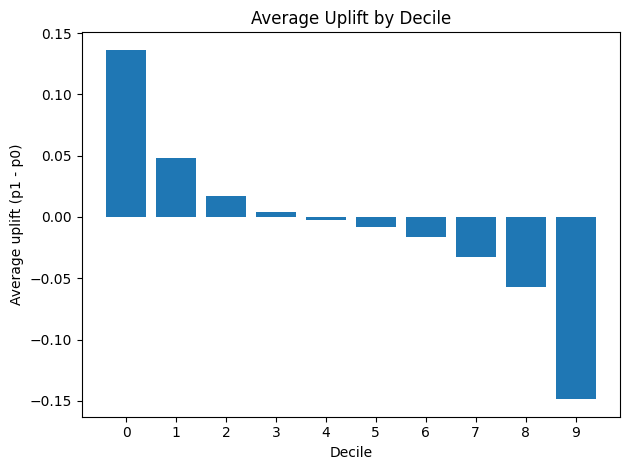

In [10]:
# Marginal Δ profit by decile
import matplotlib.pyplot as plt

plt.figure()
plt.bar(tbl["bucket"].astype(str), tbl["avg_uplift"])
plt.title("Average Uplift by Decile")
plt.xlabel("Decile")
plt.ylabel("Average uplift (p1 - p0)")
plt.tight_layout()
plt.show()